In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

import winsound

In [2]:
df = pd.read_csv('final_data.csv', encoding='utf-8')
df = df.drop(['Unnamed: 0'], axis=1)
df

,날짜,호선,역번호,역명,인원
0,2020-01-01,1호선,150,서울역,121.0
1,2020-01-01,1호선,150,서울역,-672.0
2,2020-01-01,1호선,150,서울역,-515.0
3,2020-01-01,1호선,150,서울역,-269.0
4,2020-01-01,1호선,150,서울역,-771.0
...,...,...,...,...,...
3662777,2023-10-31,8호선,2828,남위례,-535.0
3662778,2023-10-31,8호선,2828,남위례,-160.0
3662779,2023-10-31,8호선,2828,남위례,-133.0
3662780,2023-10-31,8호선,2828,남위례,-159.0


In [3]:
s = df['역명']
s

0          서울역
1          서울역
2          서울역
3          서울역
4          서울역
          ... 
3662777    남위례
3662778    남위례
3662779    남위례
3662780    남위례
3662781    남위례
Name: 역명, Length: 3662782, dtype: object

In [4]:
s = list(set(s))
s

['성수',
 '굽은다리(강동구민회관앞)',
 '동대문역사문화공원(DDP)',
 '잠원',
 '한강진',
 '돌곶이',
 '부천종합운동장',
 '신흥',
 '종합운동장',
 '미사',
 '신정(은행정)',
 '거여',
 '장암',
 '일원',
 '마장',
 '어린이대공원(세종대)',
 '강동구청',
 '응암',
 '서대문',
 '신풍',
 '산성',
 '노원',
 '청량리(서울시립대입구)',
 '동대문역사문화공원(DDP)(DDP)',
 '대흥(서강대앞)',
 '증산(명지대앞)',
 '구의(광진구청)',
 '약수',
 '잠실나루',
 '먹골',
 '장한평',
 '왕십리(성동구청)',
 '아현',
 '몽촌토성(평화의문)',
 '남성',
 '뚝섬유원지',
 '충정로(경기대입구)',
 '신사',
 '구로디지털단지',
 '신당',
 '버티고개',
 '창신',
 '월곡(동덕여대)',
 '상도',
 '경복궁(정부서울청사)',
 '수유(강북구청)',
 '마곡',
 '신답',
 '이수',
 '숙대입구(갈월)',
 '학여울',
 '논현',
 '공릉(서울과학기술대)',
 '신중동',
 '불광',
 '독바위',
 '상월곡(한국과학기술연구원)',
 '봉천',
 '건대입구',
 '신금호',
 '굴포천',
 '고덕',
 '신대방삼거리',
 '영등포구청',
 '회현(남대문시장)',
 '광흥창(서강)',
 '동대문',
 '양재(서초구청)',
 '상계',
 '마포구청',
 '안국',
 '한양대',
 '제기동',
 '봉화산(서울의료원)',
 '수락산',
 '학동',
 '당산',
 '쌍문',
 '신용산',
 '구산',
 '장지',
 '상일동',
 '복정',
 '신정네거리',
 '여의나루',
 '명동',
 '매봉',
 '방배',
 '부평구청',
 '오목교(목동운동장앞)',
 '삼각지',
 '문래',
 '화랑대(서울여대입구)',
 '종로3가',
 '송파',
 '아차산(어린이대공원후문)',
 '신림',
 '상수',
 '까치산',
 '철산',
 '용답',
 '동묘앞',
 '녹사평(용산구청)',
 '강동

In [5]:
len(s)

252

In [6]:
data1 = df[df['역명']=='서울역']
data1

,날짜,호선,역번호,역명,인원
0,2020-01-01,1호선,150,서울역,121.0
1,2020-01-01,1호선,150,서울역,-672.0
2,2020-01-01,1호선,150,서울역,-515.0
3,2020-01-01,1호선,150,서울역,-269.0
4,2020-01-01,1호선,150,서울역,-771.0
...,...,...,...,...,...
2872073,2022-12-30,1호선,150,서울역,434.0
2872074,2022-12-30,1호선,150,서울역,1126.0
2872075,2022-12-30,1호선,150,서울역,1037.0
2872076,2022-12-30,1호선,150,서울역,884.0


In [7]:
def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data) - look_back):
        dataX.append(signal_data[i:(i + look_back), 0])
        dataY.append(signal_data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 7

In [8]:
data = data1['인원']
data = data.values.astype('float32')
data = data.reshape(len(data), 1)

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

train_size = int(len(data) * 0.80)
test_size = len(data) - train_size

train = data[0:train_size]
test = data[train_size:len(data)]
x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

model = Sequential()
model.add(LSTM(512, input_shape=(None, 1), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(256, input_shape=(None, 1)))
model.add(Dropout(0.3))
model.add(Dense(1))
name = "lb7+lstm512+lstm256.jpg"
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.summary()
hist = model.fit(x_train, y_train, epochs=10, batch_size=16)
p = model.predict(x_test)

plt.plot(y_test)
plt.plot(p)
plt.legend(['testY', 'p'], loc='upper right')
plt.title(mean_squared_error(y_test, p))
plt.savefig(name)
plt.clf()
print(mean_squared_error(y_test, p))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 512)         1052672   
                                                                 
 dropout (Dropout)           (None, None, 512)         0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 1840385 (7.02 MB)
Trainable params: 1840385 (7.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
1031/10

<Figure size 640x480 with 0 Axes>

129/129 [==============================] - 3s 27ms/step


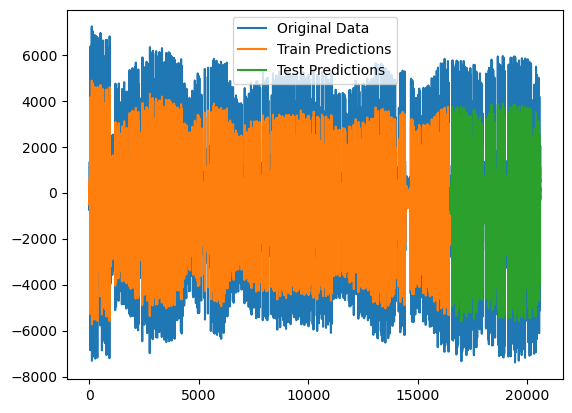

In [9]:
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([y_test])

trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(data)+2, :] = testPredict

plt.plot(scaler.inverse_transform(data), label='Original Data')
plt.plot(trainPredictPlot, label='Train Predictions')
plt.plot(testPredictPlot, label='Test Predictions')

plt.legend()
plt.show()

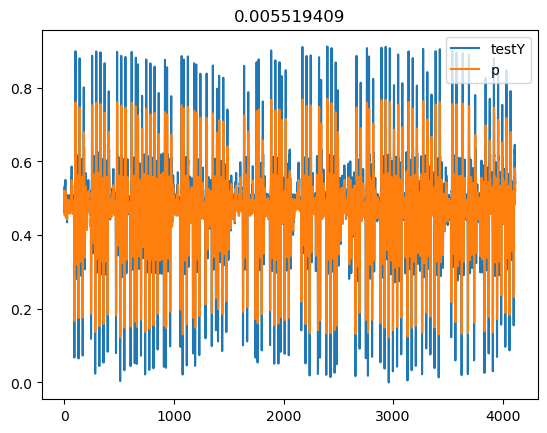

0.005519409


In [10]:
plt.plot(y_test)
plt.plot(p)
plt.legend(['testY', 'p'], loc='upper right')
plt.title(mean_squared_error(y_test, p))
plt.show()
print(mean_squared_error(y_test, p))